In [4]:
import numpy as np
import h5py
from nbodykit.lab import *
import nbodykit 
import matplotlib.pyplot as plt
import scipy.integrate
import os

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 

In [169]:
def power_spectrum(filename, L_side=0):
    print(filename)
    f = h5py.File(filename, 'r')
    divergence = f['divergence'][...]
    f.close()

    cosmo = cosmology.Planck15    
    f = cosmo.scale_independent_growth_rate(0.0)
    
    delta = -divergence/(100 * cosmo.h)
        
    delta_mesh = nbodykit.source.mesh.array.ArrayMesh(delta, L_side) 
    r = FFTPower(delta_mesh, mode='1d', dk=3/L_side, kmin=0.005)
    Pk = r.power

    return {'k': Pk['k'], 'Pk':(Pk['power'].real- Pk.attrs['shotnoise'])}

In [170]:
def compute_power_spectra(ps_dict, path="./", name="nbody", 
                          vmax=None, lbox=1.0, nside=1, sigmas=[1]):
    experiment_name = "{}_{}_{}".format(name, lbox, nside)
    ps_dict[experiment_name] = {}
    ps_dict[experiment_name]["nside"] = nside
    ps_dict[experiment_name]["name"] = name
    ps_dict[experiment_name]["lbox"] = lbox
    ps_dict[experiment_name]["sigmas"] = sigmas
    for sigma in sigmas:
        if name=="nbody":
            filename = "mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_{:.1f}_s_{:.1f}_nside_{}.hdf5".format(vmax, sigma, nside)
        elif name=="gauss":
            filename = "mock_divergence_mesh_{}_box_{}_slim_{}.h5".format(nside, lbox, sigma)        
        filename = os.path.join(path, filename)
        print(experiment_name, sigma)
        ps_dict[experiment_name][sigma] = power_spectrum(filename, L_side=lbox)
    
    return 

In [171]:
def corr_func(Pk, k):
    n_r = 1000
    r = np.linspace(0.1, 700.0, n_r)
    cf = np.zeros(n_r)
    for i in range(n_r):
        y = Pk[1:-1] * (k[1:-1]**2) * np.sin(k[1:-1]*r[i])/(k[1:-1]*r[i])
        x = k[1:-1]
        cf[i] = scipy.integrate.simps(y, x)
    cf = cf/(2.0*np.pi**2)
    
    i_min = np.argmin(np.abs(cf-cf[0]*0.2))
    half_r = r[i_min]
    #print(r[i_min])
    sigma_half_r = np.abs(r[i_min+1]-r[i_min-1])
    #sigma_half_r = 1.0
    print(cf[-1], cf[0], half_r)
    return {'cf':cf, 'r':r, 'half_r':half_r,'sigma_half_r':sigma_half_r}

In [203]:
data = {}

compute_power_spectra(data, path="../data/", 
                      name="gauss", sigmas=[2, 6, 10, 14, 20], nside=360, lbox=720)
compute_power_spectra(data, path="../data/", 
                      name="gauss", sigmas=[10, 15, 20, 30, 40], nside=100, lbox=1000)
compute_power_spectra(data, path="../data/", 
                      name="gauss", sigmas=[3, 9, 12, 15, 18], nside=100, lbox=300)
compute_power_spectra(data, path="../data/", 
                      name="nbody", vmax=300, sigmas=[2, 6, 10, 14, 20], nside=360, lbox=720)
compute_power_spectra(data, path="../data/", 
                      name="nbody", vmax=150, sigmas=[6, 12, 30, 48, 60], nside=120, lbox=720)
compute_power_spectra(data, path="../data/", 
                      name="nbody", vmax=200, sigmas=[5, 10, 20, 30, 40], nside=144, lbox=720)

gauss_720_360 2
../data/mock_divergence_mesh_360_box_720_slim_2.h5
gauss_720_360 6
../data/mock_divergence_mesh_360_box_720_slim_6.h5
gauss_720_360 10
../data/mock_divergence_mesh_360_box_720_slim_10.h5
gauss_720_360 14
../data/mock_divergence_mesh_360_box_720_slim_14.h5
gauss_720_360 20
../data/mock_divergence_mesh_360_box_720_slim_20.h5
gauss_1000_100 10
../data/mock_divergence_mesh_100_box_1000_slim_10.h5
gauss_1000_100 15
../data/mock_divergence_mesh_100_box_1000_slim_15.h5
gauss_1000_100 20
../data/mock_divergence_mesh_100_box_1000_slim_20.h5
gauss_1000_100 30
../data/mock_divergence_mesh_100_box_1000_slim_30.h5
gauss_1000_100 40
../data/mock_divergence_mesh_100_box_1000_slim_40.h5
gauss_300_100 3
../data/mock_divergence_mesh_100_box_300_slim_3.h5
gauss_300_100 9
../data/mock_divergence_mesh_100_box_300_slim_9.h5
gauss_300_100 12
../data/mock_divergence_mesh_100_box_300_slim_12.h5
gauss_300_100 15
../data/mock_divergence_mesh_100_box_300_slim_15.h5
gauss_300_100 18
../data/mock_di

In [204]:
data.keys()

dict_keys(['gauss_720_360', 'gauss_1000_100', 'gauss_300_100', 'nbody_720_360', 'nbody_720_120', 'nbody_720_144'])

In [205]:
data['gauss_300_100'].keys()

dict_keys(['nside', 'name', 'lbox', 'sigmas', 3, 9, 12, 15, 18])

In [206]:
for experiment in data.keys():
    print(experiment)
    x = data[experiment]
    for sigma in x['sigmas']:
        cf = corr_func(x[sigma]['Pk'], x[sigma]['k'])
        for c in cf.keys():
            data[experiment][sigma][c] = cf[c].copy()

gauss_720_360
1.3843019409580632e-06 0.4594234741339012 9.908408408408407
1.0390707904164652e-05 0.10150169206709267 25.321621621621624
-4.027479863262619e-06 0.04101801571703951 39.33363363363363
-1.2726191512288514e-05 0.02025430332743483 53.34564564564565
2.2362666188451098e-05 0.009012843667123753 73.66306306306305
gauss_1000_100
-1.096544237691823e-05 0.04040666666417555 39.33363363363363
9.832281924667586e-06 0.017247094398308082 56.84864864864865
2.8072833653289865e-05 0.008988052317409028 73.66306306306305
1.1274988167869974e-05 0.003227943176586131 105.89069069069069
1.0733452045582858e-05 0.0014784891429806691 132.51351351351352
gauss_300_100
-5.02810300894021e-05 0.2748367992182145 14.112012012012011
-2.218090983037425e-05 0.04666472683159365 35.13003003003003
-9.826165867795895e-05 0.026082826824730808 44.23783783783784
3.99994802315109e-05 0.017580457803223325 49.842642642642645
0.0001707038453878915 0.009022277932901373 61.05225225225225
nbody_720_360
-6.277400130166455e-

In [207]:
def plot_power_spectra(data, experiment_name):
    plt.figure(figsize=(9,7))
    sigmas = data[experiment_name]['sigmas']
    
    for i, sigma in enumerate(sigmas):
        plt.loglog(data[experiment_name][sigma]['k'], 
               data[experiment_name][sigma]['Pk'], 
               label="$R_s$={:d} Mpc $h^{{-1}}$".format(sigma),
               linewidth=i+1, color='black', alpha=0.5)

    # format the axes
    plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    plt.ylabel(r"$P_{\delta}(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
    plt.legend(fontsize=SMALL_SIZE, loc=1)
    plt.xlim(1E-2, 1)
    is_nan = np.isnan(data[experiment_name][sigma]['Pk'])
    max_pk = np.max(data[experiment_name][sigma]['Pk'][~is_nan])
    plt.ylim(max_pk/1000,2*max_pk)
    plt.title(r"Type={},\ $L_b={},\ N_s={}$".format(
        data[experiment_name]["name"], data[experiment_name]["lbox"], data[experiment_name]["nside"]))
    #plt.title(r"\verbatim{{}}".format(experiment_name))
    plt.savefig("power_spectrum_{}.pdf".format(experiment_name), bbox_inches='tight')

In [208]:
def plot_correlation_function(data, experiment_name):
    plt.figure(figsize=(9,7))
    sigmas = data[experiment_name]['sigmas']
    
    for i, sigma in enumerate(sigmas):
        plt.loglog(data[experiment_name][sigma]['r'], 
               data[experiment_name][sigma]['cf'], 
               label="$R_s$={:d} Mpc $h^{{-1}}$".format(sigma),
               linewidth=i+1, color='black', alpha=0.5)

    # format the axes
    plt.xlabel(r"$r$ [$\mathrm{Mpc}\ h^{-1}$]")
    plt.ylabel(r"$\xi_{\delta\delta}(r)$")
    plt.legend(fontsize=SMALL_SIZE, loc=1)
    plt.xlim(1.0, 2E2)
    y_max = np.max(data[experiment_name][sigmas[0]]['cf'])
    y_min = np.max(data[experiment_name][sigmas[-1]]['cf'])
    plt.ylim(y_min/10,1.5*y_max)
    plt.title(r"Type={},\ $L_b={},\ N_s={}$".format(
        data[experiment_name]["name"], data[experiment_name]["lbox"], data[experiment_name]["nside"]))
    #plt.title(r"\verbatim{{}}".format(experiment_name))
    plt.savefig("corr_func_{}.pdf".format(experiment_name), bbox_inches='tight')

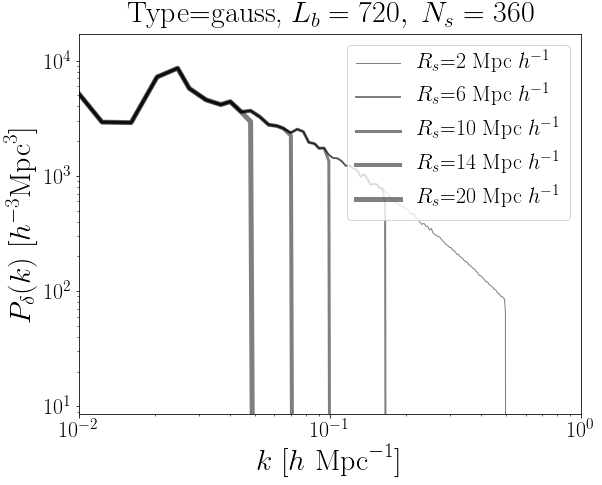

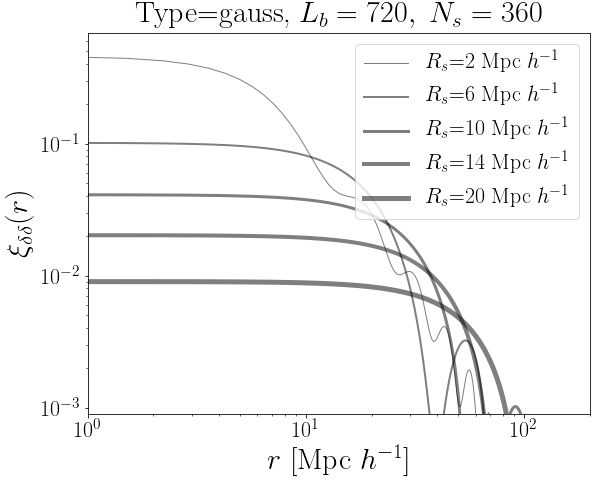

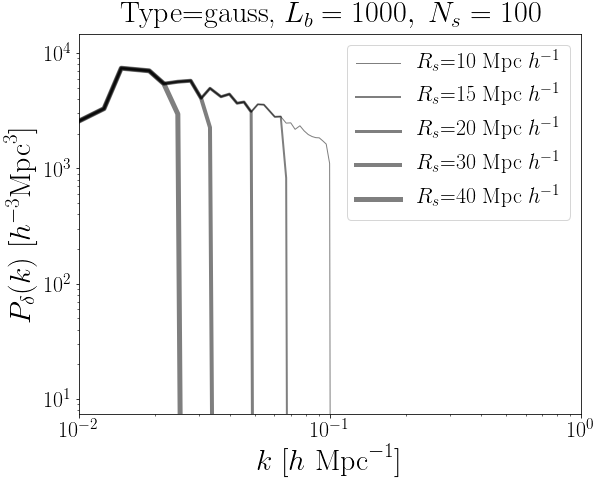

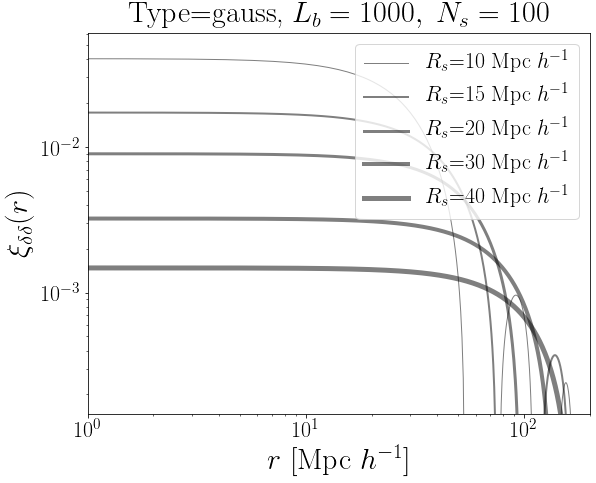

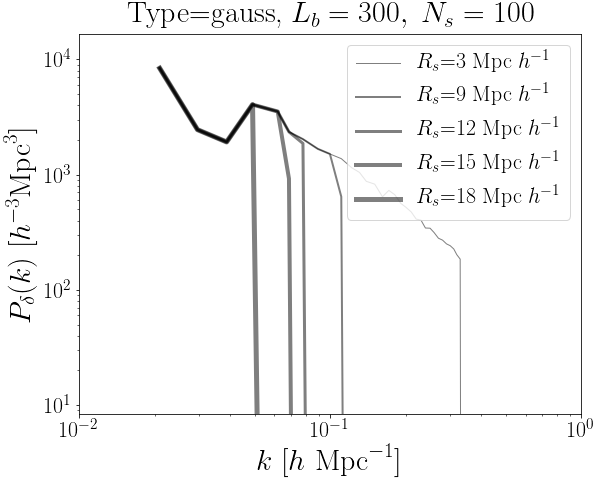

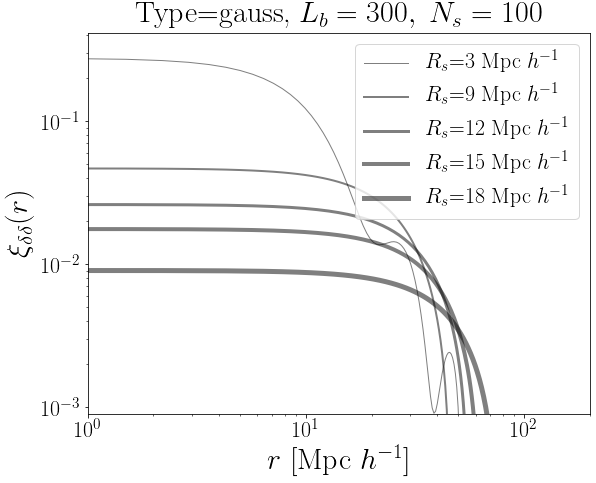

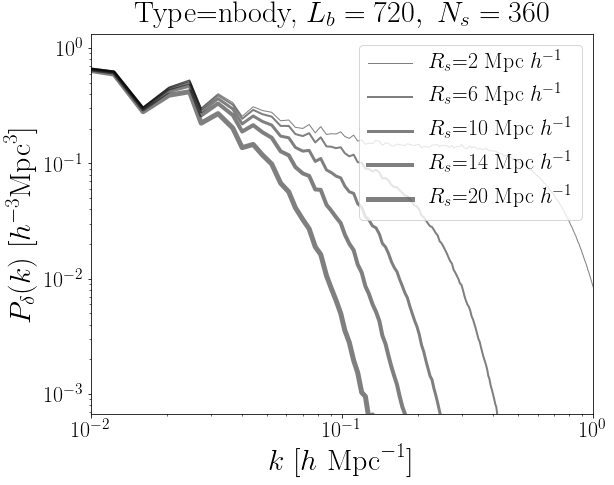

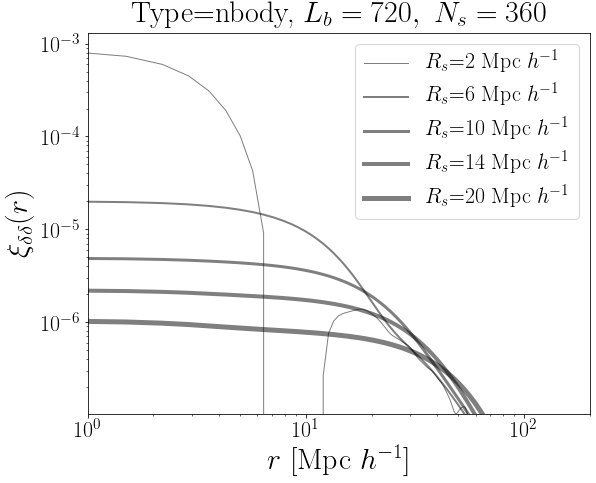

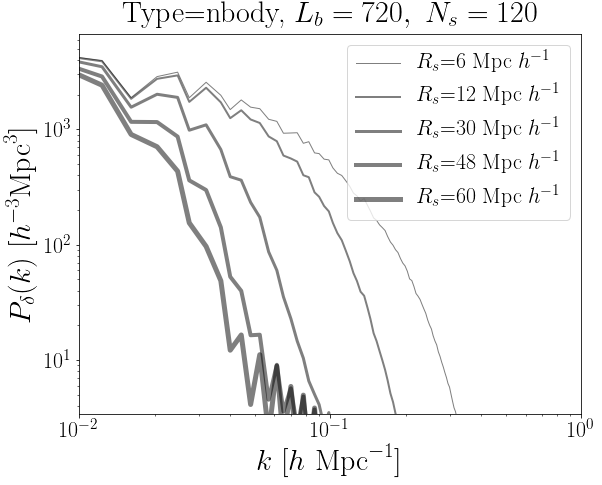

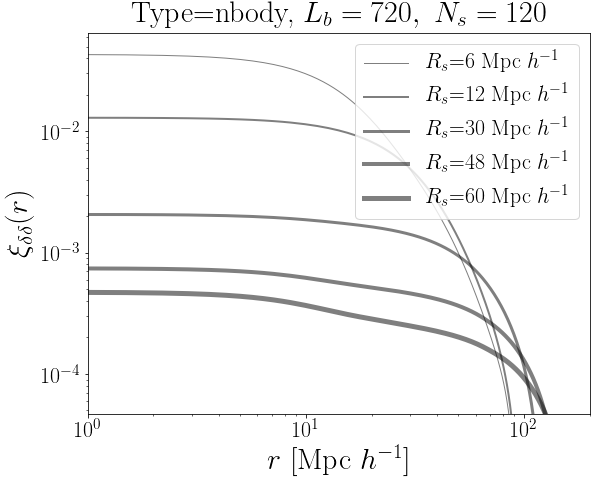

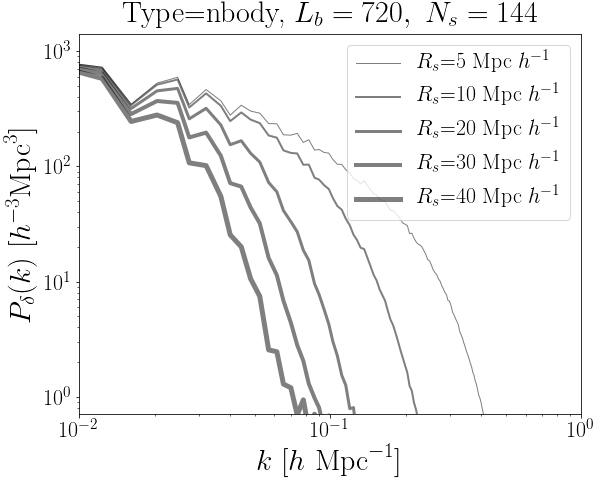

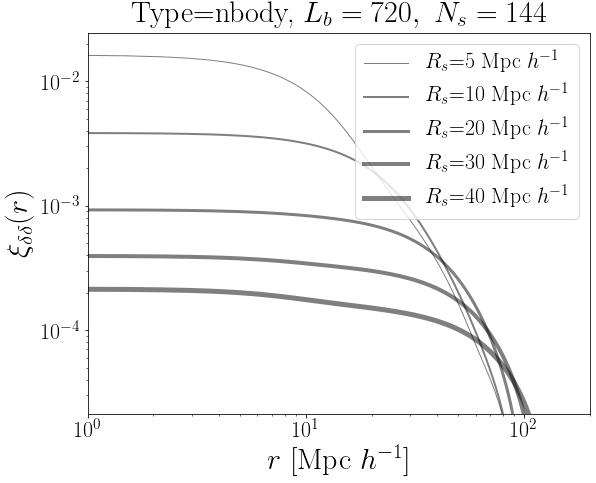

In [209]:
for experiment in data.keys():
    plot_power_spectra(data, experiment)
    plot_correlation_function(data, experiment)

In [213]:
half_r_abacus = []
half_r_gauss = []
sigma_half_r_abacus = []
sigma_half_r_gauss = []

sigmas_gauss = np.array(sigmas_gauss)
sigmas_abacus = np.array(sigmas_abacus)

for sigma_gauss, sigma_abacus in zip(sigmas_gauss, sigmas_abacus):
    half_r_abacus.append(cf["abacus_{:.1f}".format(sigma_abacus)]["half_r"])
    half_r_gauss.append(cf["gauss_{:.1f}".format(sigma_gauss)]["half_r"])
    sigma_half_r_abacus.append(cf["abacus_{:.1f}".format(sigma_abacus)]["sigma_half_r"])
    sigma_half_r_gauss.append(cf["gauss_{:.1f}".format(sigma_gauss)]["sigma_half_r"])

    
half_r_abacus = np.array(half_r_abacus)
half_r_gauss = np.array(half_r_gauss)
sigma_half_r_abacus = np.array(sigma_half_r_abacus)
sigma_half_r_gauss = np.array(sigma_half_r_gauss)


In [214]:
A = np.array([sigmas_gauss, half_r_gauss])
np.savetxt("correlation_length_gauss.dat", A.T, fmt="%.1f",
           header='R_s R_dd')

A = np.array([sigmas_abacus, half_r_abacus])
np.savetxt("correlation_length_abacus.dat", A.T, fmt="%.1f",
           header='R_s R_dd')

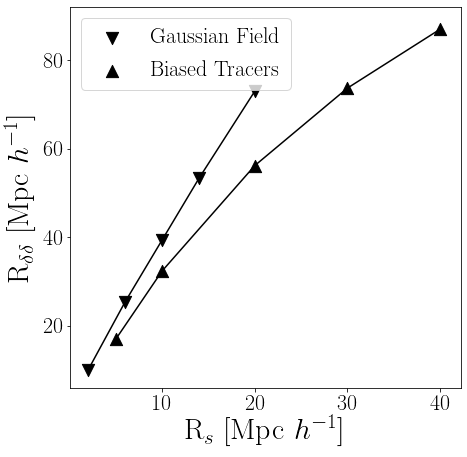

In [215]:
plt.figure(figsize=(7,7))

plt.scatter(sigmas_gauss, half_r_gauss, marker="v", s=150, label="Gaussian Field", color='black')
plt.plot(sigmas_gauss, half_r_gauss, color='black')
#plt.errorbar(sigma_vals, half_r_mock, yerr=sigma_half_r_mock, color='black', capsize=10)


plt.scatter(sigmas_abacus, half_r_abacus, marker="^", s=150, label="Biased Tracers", color='black')
plt.plot(sigmas_abacus, half_r_abacus, color='black')
#plt.errorbar(sigma_vals, half_r_sim, yerr=sigma_half_r_sim, color='black', capsize=10)


#plt.plot(sigma_vals, 3*sigma_vals, color='black', label='$R_{\delta\delta}=3R_{s}$', alpha=0.4)

#plt.semilogy()
#plt.xlim(0,22)
#plt.ylim(0,32)
plt.legend(fontsize=SMALL_SIZE)
plt.xlabel(r"R$_s$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"R$_{\delta\delta}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.savefig("correlation_length.pdf", bbox_inches='tight')

In [168]:
#https://cluster-toolkit.readthedocs.io/en/latest/source/correlation_functions.html

In [48]:
720/60

12.0